### Price several exotic options through Monte-Carlo algorithm (crude, control variate, etc)

#### By Michael Liang


In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from math import *

np.random.seed(402)

In [ ]:
# Cumulative normal distribution
def CND(X):
    return norm.cdf(X)

# Black Sholes Function
def BlackScholes(CallPutFlag,S,K,t,r,sigma):
    """
    S = Current stock price
    t = Time until option exercise (years to maturity)
    K = Option striking price
    r = Risk-free interest rate
    N = Cumulative standard normal distribution
    e = Exponential term
    sigma = St. Deviation (volatility)
    Ln = NaturalLog
    """
    d1 = (log(S/K) + (r + (sigma ** 2)/2) * t)/(sigma * sqrt(t))
    d2 = d1 - sigma * sqrt(t)

    if CallPutFlag=='c':
        return S * CND(d1) - K * exp(-r * t) * CND(d2) # call option
    else:
        return K * exp(-r * t) * CND(-d2) - S * CND(-d1) # put option 

### Exercise 1:
Implement the crude Monte-Carlo algorithm to estimate the price of a European put option with parameters S0 = 100, r = 0.0175, σ = 0.4, T = 1, K = 98. Use N = 102, 103, 104, 105, 106 normal random variables to generate the terminal asset price needed. 

Report your estimates and a 95% confidence interval for each N. Compare your results to the Black-Scholes price.

In [ ]:
BS_put = BlackScholes('p',S=100,K=98,t=1,r=0.0175,sigma=0.4)
# Estimate the price of a european put option with the crude Monte Carlo algo


simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6,10**7 ]
T = 1
K = 98
r = 0.0175
sigma = 0.4 
Put_hat, CI, MSE = [], [], [] 
eff_CR,abs_error_CR =[], [] 

St = 100
for N in simulation_size:
    
    Z = np. random.normal(0, 1, N) # vector of normal RV
    sim_St = St * np.exp((r-0.5*sigma**2)*T + sigma*np.sqrt(T)*Z) # GBM
    put__payoff = np.maximum(K-sim_St,0) # payoff of put option
    disc_put_payoff = np.exp(-r*T)*put__payoff
    tempsum = np.sum(disc_put_payoff)
    tempsum2 = np.sum(disc_put_payoff**2)

    crude_MC = tempsum / N # compute crude Monte Carlo

    # compute variance of crude MC
    s2 = tempsum2/(N-1) - (N/(N-1))*crude_MC**2
    mse = s2/N
    upper_CI = crude_MC +1.96*(mse**0.5)
    lower_CI = crude_MC -1.96*(mse**0.5)
    ci = [lower_CI, upper_CI]
    
    #efficiency
    eff = 1 / mse
    error = abs(BS_put - crude_MC)
    
    Put_hat.append(crude_MC)
    MSE.append(mse)
    CI.append(ci)
    eff_CR.append(eff)
    abs_error_CR.append(error)

results_crude_MC = pd.DataFrame({'N':['10^2','10^3','10^4','10^5','10^6','10^7'], 'P0_hat':Put_hat, 'MSE':MSE, '95% CI':CI,
                                 'Abs. Error': abs_error_CR, 'Efficiency': eff_CR })

print("Exercise 1a: Price put option by Monte Carlo Simulation")
print (f'\n Put option price with BS model: {BS_put.round(5)}')

display(results_crude_MC)



Question 1a: Price put option by Monte Carlo Simulation

 Put option price with BS model: 13.77677


,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,10^2,12.793627,2.824234,"[9.499757012371736, 16.087496642409036]",0.983144,0.354078
1,10^3,14.988202,0.317161,"[13.884386879409877, 16.092016698032403]",1.211431,3.152968
2,10^4,13.935574,0.029712,"[13.597727438201565, 14.273420138384056]",0.158803,33.656866
3,10^5,13.835519,0.002971,"[13.728689340042902, 13.942347896759564]",0.058747,336.613518
4,10^6,13.751648,0.000296,"[13.71792993250832, 13.785365378989002]",0.025124,3379.058103
5,10^7,13.783000,0.000030,"[13.77232102822833, 13.793678264430579]",0.006228,33688.527789


### Exercise 1b

Price put option by the antithetic variates method

In [ ]:
#Antithetic mehtod
Put_hat_AV, CI_AV, MSE_AV = [], [], [] 
eff_AV,abs_error_AV =[], [] 



def put_option_antithetic(St,K,t,r,sigma, simulation_size):
    disc_factor = np.exp(-r*T)
    for N in simulation_size:
        N = int(N/2)
        Z = np. random.normal(0, 1, N)

        sim_St1 = St * np.exp((r-0.5*sigma**2)*T + sigma*sqrt(T)*Z)
        disc_put_payoff1 = disc_factor * np.maximum(K-sim_St1,0)

        # we have the antithetic variates is -Z since mean of normal dist. is zero
        sim_St2 = St * np.exp((r-0.5*sigma**2)*T + sigma*sqrt(T)*-Z) 
        disc_put_payoff2 = disc_factor * np.maximum(K-sim_St2,0)


        disc_put_payoff = (disc_put_payoff1 + disc_put_payoff2) / 2

        tempsum = np.sum(disc_put_payoff)
        tempsum2 = np.sum(disc_put_payoff**2)

        AV = tempsum / N # compute crude Monte Carlo
        # compute variance of crude MC
        s2 = tempsum2/(N-1) - (N/(N-1))*AV**2 
        mse = s2/N

        upper_CI = AV +1.96*(mse**0.5)
        lower_CI = AV -1.96*(mse**0.5)
        ci = [lower_CI, upper_CI]

        #efficiency and error
        eff = 1 / mse
        error = abs(BS_put - AV)

        Put_hat_AV.append(AV)
        CI_AV.append(ci)
        MSE_AV.append(mse)
        eff_AV.append(eff)
        abs_error_AV.append(error)

    results_antithetic = pd.DataFrame({'N':simulation_size, 'P0_hat':Put_hat_AV, 
                                           'MSE':MSE_AV, '95% CI':CI_AV, 'Abs. Error': abs_error_AV, 'Efficiency': eff_AV })
    return results_antithetic

retults_put_ant = put_option_antithetic(St =100,K=98,t=1,r=0.0175,sigma=0.4,simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6,10**7 ])

BS_put = BlackScholes('p',S=100,K=98,t=1,r=0.0175,sigma=0.4)
print("Exercise 1b: Price put option by Antithetic variates")
print (f'\n Put option price with BS model: {BS_put.round(5)}')

display(retults_put_ant)



Question 1b: Price put option by Antithetic variates

 Put option price with BS model: 13.77677


,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,100,13.148924,1.028170,"[11.161509222808096, 15.136339332135034]",0.627847,0.972602
1,1000,14.187370,0.112400,"[13.530257865513944, 14.844482714402423]",0.410599,8.896779
2,10000,13.854507,0.010760,"[13.651192872457449, 14.057820198730662]",0.077735,92.934938
3,100000,13.796790,0.001086,"[13.732201863323727, 13.861377305359579]",0.020018,920.899466
4,1000000,13.781717,0.000108,"[13.761315405537498, 13.802119197059966]",0.004946,9229.349538
5,10000000,13.778446,0.000011,"[13.772004524468656, 13.784887264400862]",0.001675,92588.202911


### Exercise 1b continue

Comparing models' efficiency between Monte Carlo and Antithetic variates 

In [ ]:


eff_change = (results_antithetic['Efficiency'] - results_crude_MC['Efficiency'])/results_crude_MC['Efficiency'] *100
print('Compare to Monte-Carlo, Antithetic Variates increases efficiency (in %)')
display(pd.DataFrame({'N': simulation_size, 'change in efficiency': eff_change}))

Compare to Monte-Carlo, Antithetic Variates increases efficiency (in %)


,N,change in efficiency
0,100,78.057478
1,1000,163.239201
2,10000,171.496680
3,100000,175.507998
4,1000000,173.803050
5,10000000,174.917319


### Exercise 2



In [ ]:
def geometric_brownian_motion_path(St0 = 5, r = 0.05, T= 1, sigma=0.3, timesteps = 10**4):
    """
    Calculates an asset price path using the analytical solution
    to the Geometric Brownian Motion stochastic

    Parameters
    ----------
    St0 : `integer`
        initial stock price
    r : `float`
        interest rate
    T : `float`
        last time node       
    sigma : `float`
        instrument volatility
    timesteps : `integer`
        number of discretization steps
        
    Returns
    -------
    `np.ndarray`
        The asset price path 
    """
    n = timesteps
    dt = T /  n 
    
    # Vectorised implementation of asset path generation
    
    asset_path = np.exp(
           (r - 0.5* sigma**2 ) * dt +
           sigma * np.sqrt(dt) * np.random.normal(0, 1, size= timesteps)
        )
    
    return St0 * np.cumprod(asset_path, axis=0)

In [ ]:
def geometric_brownian_motion_paths(St0 = 5, r = 0.05, T= 1, sigma=0.3, timesteps = 10**4, sim_nbr = 10**3):
    """
    Generate N simulation of GBM asset price paths and return its respective max, last price, and avg price (arithmetic and geometric)

    Parameters
    ----------
    St0 : `integer`
        initial stock price
    r : `float`
        interest rate
    T : `float`
        last time node       
    sigma : `float`
        instrument volatility
    timesteps : `integer`
        number of discretization steps
    simulation_nbr : `integer`
        number of discretization steps        
    Returns
    -------
    `np.ndarray`
        The asset price path 
    """
    n = timesteps
    dt = T /  n 
    batch_size =500
    if sim_nbr < batch_size:
        row_matrix =sim_nbr
    else:
        row_matrix = batch_size
        
    
    batches = int(sim_nbr / batch_size) + (sim_nbr % batch_size > 0)
    Last_price = []
    Max_price = []
    Avg_path_price = []
    Geo_avg_price = []
    # Vectorised implementation of asset path generation
    const = np.exp((r - 0.5 * sigma**2) * dt)
    const2 = sigma * np.sqrt(dt)
    
    for batch in range(int(batches)):
        Z = np.random.normal(0, 1, size= (row_matrix, timesteps))
        
        temp = const * np.exp(const2 * Z)
        path = St0 * np.cumprod(temp, axis=1)
        
        avg_path = np.mean(path, axis =1)
        geo_mean_path = np.exp(np.mean(np.log(path), axis =1))
        max_px = np.amax(path, axis=1)
        last_px = path[:,-1]  
        
        Last_price = np.append(Last_price, last_px)
        Max_price = np.append(Max_price, max_px)
        Avg_path_price = np.append(Avg_path_price, avg_path) 
        Geo_avg_price = np.append(Geo_avg_price, geo_mean_path) 

    
    
    return Last_price, Max_price, Avg_path_price, Geo_avg_price

### Exercise 2a

Generate a GBM path and return its max and last price

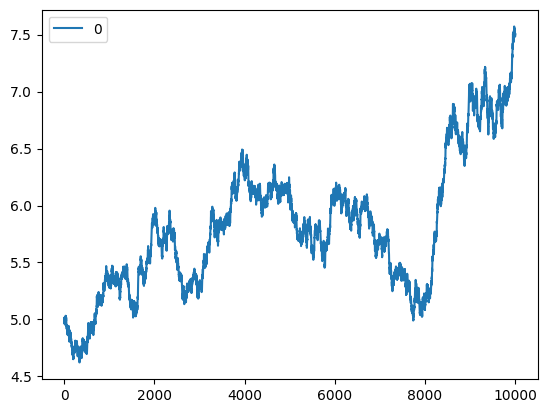

{'Max price': array([7.57149456]), 'Last price:': array([7.50327577])}


C:\Users\Michael\anaconda3\envs\Python - R-Studio\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
gbm_path= geometric_brownian_motion_path(St0 = 5, r = 0.05, T= 1, sigma=0.3, timesteps = 10**4)

gbm_path = pd.DataFrame(gbm_path)
gbm_path.plot()

plt.show()

last_px = gbm_path.iloc[-1].values
max_px = np.max(gbm_path).values
print({'Max price':max_px,  'Last price:': last_px })
    

### Exercise 2b, c 
Pricing In and Out Call option using crude Monte- Carlo method

In [ ]:

St_0 = 5
N = 10**5 #simulations size
T = 1
K = 6
barrier = 8
r = 0.05
sigma = 0.30
timesteps = 10**4



node_array= geometric_brownian_motion_paths(sim_nbr = N) #np.array(list(map(max_last_px, arr)))
payoff = np.where((node_array[1] > barrier) , np.maximum(node_array[0]-K,0) , 0)

disc_payoff = np.exp(-r*T)* payoff
tempsum = np.sum(disc_payoff)
tempsum2 = np.sum(disc_payoff**2)
crude_MC = tempsum / N # compute crude Monte Carlo

# compute variance of crude MC
s2 = (tempsum2 - N*crude_MC**2)/(N-1)
mse = s2/N
upper_CI = crude_MC +1.96*(mse**0.5)
lower_CI = crude_MC -1.96*(mse**0.5)
ci = [lower_CI, upper_CI]
    
#efficiency
eff = 1 / mse
BS_call = 0.24
error = abs(BS_call - crude_MC)


results_up_in_call = pd.DataFrame({'N':[N], 'P0_hat':[crude_MC], 
                                       'MSE':[mse], '95% Confidence Interval':[ci], 'Abs. Error': [error], 'Efficiency': [eff] })


print ('Pricing In and Out Call option using crude Monte- Carlo method')
print (f'\n In & Out Call option price with BS model: {BS_call}')
display(results_up_in_call)



Pricing In and Out Call option using crude Monte- Carlo method

 In & Out Call option price with BS model: 0.24


,N,P0_hat,MSE,95% Confidence Interval,Abs. Error,Efficiency
0,100000,0.246558,0.000007,"[0.24155381395679754, 0.2515628053123529]",0.006558,153388.042708


### Exercise 2d

Compute in and out call option using antithetic variates method


In [ ]:
def geometric_brownian_motion_paths_arithmetic(St0 = 5, r = 0.05, T= 1, sigma=0.3, timesteps = 10**4, sim_nbr = 10**3):
    """
    Parameters
    ----------
    St0 : `integer`
        initial stock price
    r : `float`
        interest rate
    T : `float`
        last time node       
    sigma : `float`
        instrument volatility
    timesteps : `integer`
        number of discretization steps
    simulation_nbr : `integer`
        number of discretization steps        
    Returns
    -------
    `np.ndarray`
        The asset price path 
    """
    n = timesteps
    dt = T /  n 

    Last_price = []
    Max_price = []
    Avg_path_price =[]
    
    Last_price_av = []
    Max_price_av = []
    Avg_path_price_AV =[]
    
    # Vectorised implementation of asset path generation
    const = np.exp((r - 0.5 * sigma**2) * dt)
    const2 = sigma * np.sqrt(dt)
    
    #devide simulation into batches to reduce computing power cause by the normal rv matrixes 
    batch_size =500
    if sim_nbr < batch_size:
        row_matrix =sim_nbr
    else:
        row_matrix = batch_size
        
    
    batches = int(sim_nbr / batch_size) + (sim_nbr % batch_size > 0)
    
    for batch in range(int(batches)):
        Z = np.random.normal(0, 1, size= (row_matrix, timesteps))
        
        temp = const * np.exp(const2 * Z)
        path = St0 * np.cumprod(temp, axis=1)
        max_px1 = np.amax(path, axis=1)
        last_px1 = path[:,-1]
        avg_path1 = np.mean(path, axis =1)
        
        temp2 = const * np.exp(const2 * -Z)
        path2 = St0 * np.cumprod(temp2, axis=1)
        max_px2 = np.amax(path2, axis=1)
        last_px2 = path2[:,-1]
        avg_path2 = np.mean(path2, axis =1)
        
        Last_price = np.append(Last_price, last_px1)
        Max_price = np.append(Max_price, max_px1)
        Avg_path_price = np.append(Avg_path_price, avg_path1)
        
        Last_price_av = np.append(Last_price_av, last_px2)
        Max_price_av = np.append(Max_price_av, max_px2)     
        Avg_path_price_AV = np.append(Avg_path_price_AV, avg_path2)


    
    return Last_price, Max_price, Avg_path_price, Last_price_av, Max_price_av, Avg_path_price_AV #return array of last, max, avg price for antithetic)

In [ ]:

St_0 = 5
N = (10**5)/2 #simulations size
T = 1
K = 6
barrier = 8
r = 0.05
sigma = 0.30
timesteps = 10**4


#anthitetic variates


node_array= geometric_brownian_motion_paths_arithmetic(sim_nbr = N)

payoff1 = np.where((node_array[1] > barrier) , np.maximum(node_array[0]-K,0) , 0)
disc_payoff1 = np.exp(-r*T)* payoff1

payoff2 = np.where((node_array[4] > barrier) , np.maximum(node_array[3]-K,0) , 0)
disc_payoff2 = np.exp(-r*T)* payoff2

disc_payoff = (disc_payoff2 +disc_payoff1)/2



tempsum = np.sum(disc_payoff)
tempsum2 = np.sum(disc_payoff**2)
#N = N/2

crude_MC = tempsum / N # compute crude Monte Carlo

# compute variance of crude MC
s2 = (tempsum2 - N*(crude_MC**2))/(N-1)
mse = s2/N
upper_CI = crude_MC +1.96*(mse**0.5)
lower_CI = crude_MC -1.96*(mse**0.5)
ci = [lower_CI, upper_CI]
    
#efficiency
eff = 1 / mse
BS_call = 0.24
error = abs(BS_call - crude_MC)


results_up_in_call = pd.DataFrame({'N':[N], 'P0_hat':[crude_MC], 
                                       'MSE':[mse], '95% Confidence Interval':[ci], 'Abs. Error': [error], 'Efficiency': [eff] })

print('Compute In and Out call option using antithetic variates method')
print (f'\n In & Out Call option price with BS model: {BS_call}')
display(results_up_in_call)


Compute In and Out call option using antithetic variates method

 In & Out Call option price with BS model: 0.24


,N,P0_hat,MSE,95% Confidence Interval,Abs. Error,Efficiency
0,50000.0,0.249833,0.000006,"[0.24502300103011881, 0.2546435989323766]",0.009833,166022.90439


### Exercise 4a:
Generate GBM path

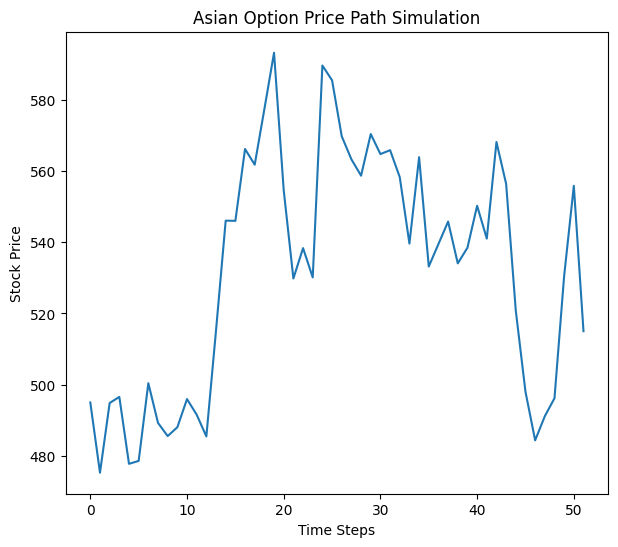

In [ ]:
asian_option_path = geometric_brownian_motion_path(St0 = 500, r = 0.0175, T= 1, sigma=0.25, timesteps = 52)

plt.figure(figsize=(7,6))
plt.plot(asian_option_path)

plt.title('Asian Option Price Path Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

### Exercise 4b:
Pricing arithmetic and geometric asian option using Monte Carlo

In [ ]:
# Monde Carlo Arithmetic Asian Option

def arith_geo_asian_option(St0,r,sigma,K,T,timesteps,simulation_size):
    Put_hat_ari, CI_ari, MSE_ari = [], [], [] 
    eff_CR_ari, abs_error_CR_ari =[], [] 

    Put_hat_geo, CI_geo, MSE_geo = [], [], [] 
    eff_CR_geo ,abs_error_CR_geo =[], [] 

    #gbm_path = geometric_brownian_motion_paths(St_0, r, sigma, timesteps)

    
    for N in simulation_size:
        node_array= geometric_brownian_motion_paths(St0,r,T,sigma,timesteps,N) 
        #Arithmetic Mean Asian Option
        payoff_ari = np.maximum(node_array[2]-K, 0)
        disc_payoff_ari = np.exp(-r*T)* payoff_ari

        tempsum_ari = np.sum(disc_payoff_ari)
        tempsum2_ari = np.sum(disc_payoff_ari**2)
        crude_MC_ari = tempsum_ari / N # compute crude Monte Carlo

        # compute variance of crude MC
        s2_ari = (tempsum2_ari - N*(crude_MC_ari**2))/(N-1)
        mse_ari = s2_ari/N
        upper_CI_ari = crude_MC_ari +1.96*(mse_ari**0.5)
        lower_CI_ari = crude_MC_ari -1.96*(mse_ari**0.5)
        ci_ari = [lower_CI_ari, upper_CI_ari]

        #efficiency
        eff_ari = 1 / mse_ari
        BS_call = 31.04967
        error_ari = abs(BS_call - crude_MC_ari)

        Put_hat_ari.append(crude_MC_ari)
        MSE_ari.append(mse_ari)
        CI_ari.append(ci_ari)
        eff_CR_ari.append(eff_ari)
        abs_error_CR_ari.append(error_ari)


        #geometric Mean Asian Option
        payoff_geo = np.maximum(node_array[3]-K, 0)
        disc_payoff_geo = np.exp(-r*T)* payoff_geo

        tempsum_geo = np.sum(disc_payoff_geo)
        tempsum2_geo = np.sum(disc_payoff_geo**2)
        crude_MC_geo = tempsum_geo / N # compute crude Monte Carlo

        # compute variance of crude MC
        s2_geo = (tempsum2_geo - N*(crude_MC_geo**2))/(N-1)
        mse_geo = s2_geo/N
        upper_CI_geo = crude_MC_geo +1.96*(mse_geo**0.5)
        lower_CI_geo = crude_MC_geo -1.96*(mse_geo**0.5)
        ci_geo = [lower_CI_geo, upper_CI_geo]

        #efficiency
        eff_geo = 1 / mse_geo
        BS_call_geo = 29.62416
        error_geo = abs(BS_call_geo - crude_MC_geo)

        Put_hat_geo.append(crude_MC_geo)
        MSE_geo.append(mse_geo)
        CI_geo.append(ci_geo)
        eff_CR_geo.append(eff_geo)
        abs_error_CR_geo.append(error_geo)


    results_asian_option_MC_ari =  pd.DataFrame({'N':simulation_size, 'Arith.  Asian Option Price':Put_hat_ari, 'MSE':MSE_ari, '95% CI':CI_ari,
                                     'Abs. Error': abs_error_CR_ari, 'Efficiency': eff_CR_ari })

    results_asian_option_MC_geo =  pd.DataFrame({'N':simulation_size, 'Geo. Asian Option Price':Put_hat_geo, 'MSE':MSE_geo, '95% CI':CI_geo,
                                     'Abs. Error': abs_error_CR_geo, 'Efficiency': eff_CR_geo })
    return results_asian_option_MC_ari, results_asian_option_MC_geo




In [ ]:

asian_option = arith_geo_asian_option(St0 = 500, r = 0.0175, K =500, T= 1, sigma=0.25, timesteps = 52, 
                                      simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6] )



print('Arithmetic Asian Option Price Path Simulation')
display(asian_option[0])

print('Geometric Asian Option Price Path Simulation')
display(asian_option[1])


Arithmetic Asian Option Price Path Simulation


,N,Arith. Asian Option Price,MSE,95% CI,Abs. Error,Efficiency
0,100,36.689162,29.869603,"[25.97715583016864, 47.40116733884376]",5.639492,0.033479
1,1000,33.759715,2.449168,"[30.69235036641104, 36.82707869781543]",2.710045,0.408302
2,10000,29.972156,0.221108,"[29.050523649209257, 30.89378887102772]",1.077514,4.522686
3,100000,30.776555,0.023336,"[30.477144641410916, 31.075965658542856]",0.273115,42.852688
4,1000000,31.089830,0.002358,"[30.99464786345175, 31.185011309761745]",0.040160,424.038234


Geometric Asian Option Price Path Simulation


,N,Geo. Asian Option Price,MSE,95% CI,Abs. Error,Efficiency
0,100,34.692023,26.538971,"[24.594889328910533, 44.78915679223898]",5.067863,0.037680
1,1000,32.224727,2.256873,"[29.280240337831447, 35.16921413621365]",2.600567,0.443091
2,10000,28.586362,0.203510,"[27.702165815416063, 29.470557591131826]",1.037798,4.913774
3,100000,29.360490,0.021463,"[29.073347764953645, 29.647631672701074]",0.263670,46.592803
4,1000000,29.660138,0.002169,"[29.568860855962054, 29.751415385481085]",0.035978,461.091279


In [ ]:
S0 = 500
simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6] #simulations size
T = 1
K = 500

r = 0.0175
sigma = 0.25
timesteps = 52

arith, geo = arith_geo_asian_option(S0,r,sigma,K,T,timesteps,simulation_size)

In [ ]:
# Monde Carlo GEOMETRIC Asian Option
St_0 = 500
simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6] #simulations size
T = 1
K = 500

r = 0.0175
sigma = 0.25
timesteps = 52

Put_hat, CI, MSE = [], [], [] 
eff_CR,abs_error_CR =[], [] 

#gbm_path = geometric_brownian_motion_paths(St_0, r, sigma, timesteps)

#Suppose r = 0.0175, σ = 0.25, S0 = 500, K = S0, T = 1, and n = 52.
#arr = np.array([1]*(N))
for N in simulation_size:
    node_array= geometric_brownian_motion_paths(St0 = 500, r = 0.0175, T= 1, sigma=0.25, timesteps = 52, sim_nbr = N) #np.array(list(map(max_last_px, arr)))
    #slit_array = np.hsplit(node_array, 2)
    #last_px, max_px = slit_array[0], slit_array[1]

    
    payoff = np.maximum(node_array[3]-K, 0)
    #nbr_payoff_exercisable = np.sum(payoff != 0)#np.sum((node_array[:,1] > barrier) & (node_array[:,0] > K))

    disc_payoff = np.exp(-r*T)* payoff
    tempsum = np.sum(disc_payoff)
    tempsum2 = np.sum(disc_payoff**2)

    crude_MC = tempsum / N # compute crude Monte Carlo

    # compute variance of crude MC
    s2 = (tempsum2 - N*(crude_MC**2))/(N-1)
    mse = s2/N
    upper_CI = crude_MC +1.96*(mse**0.5)
    lower_CI = crude_MC -1.96*(mse**0.5)
    ci = [lower_CI, upper_CI]

    #efficiency
    eff = 1 / mse
    BS_call = 0.24
    error = abs(BS_call - crude_MC)
    
    Put_hat.append(crude_MC)
    MSE.append(mse)
    CI.append(ci)
    eff_CR.append(eff)
    abs_error_CR.append(error)


results_asian_option_MC =  pd.DataFrame({'N':['10^2','10^3','10^4','10^5','10^6'], 'P0_hat':Put_hat, 'MSE':MSE, '95% CI':CI,
                                 'Abs. Error': abs_error_CR, 'Efficiency': eff_CR })


display(results_asian_option_MC)




,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,10^2,30.253897,22.141551,"[21.031154698235312, 39.47663986602072]",30.013897,0.045164
1,10^3,30.057715,2.219281,"[27.13785432946276, 32.97757649584326]",29.817715,0.450596
2,10^4,29.252415,0.212434,"[28.349039914009072, 30.15579002107172]",29.012415,4.707344
3,10^5,29.634462,0.021728,"[29.345548887764267, 29.923374804665322]",29.394462,46.023336
4,10^6,29.552481,0.002157,"[29.461450745870554, 29.643511196496913]",29.312481,463.597310


### Exercise 4c:
Pricing arithmetic asian option using antithetic variates 

In [ ]:
# Antithetic Variates Asian Option
St_0 = 500
simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6] #simulations size
T = 1
K = 500

r = 0.0175
sigma = 0.25
timesteps = 52

Put_hat, CI, MSE = [], [], [] 
eff_CR,abs_error_CR =[], [] 

#gbm_path = geometric_brownian_motion_paths(St_0, r, sigma, timesteps)

#Suppose r = 0.0175, σ = 0.25, S0 = 500, K = S0, T = 1, and n = 52.
#arr = np.array([1]*(N))
for N in simulation_size:
    node_array= geometric_brownian_motion_paths_arithmetic(St0 = 500, r = 0.0175, T= 1, sigma=0.25, timesteps = 52, sim_nbr = N) 
    #slit_array = np.hsplit(node_array, 2)
    #last_px, max_px = slit_array[0], slit_array[1]

    payoff1 = np.maximum(node_array[2]-K, 0)
    disc_payoff1 = np.exp(-r*T)* payoff1
    
    payoff2 = np.maximum(node_array[5]-K, 0) #anthitetic 
    disc_payoff2 = np.exp(-r*T)* payoff2
    
    disc_payoff = (disc_payoff2 +disc_payoff1)/2
    
    tempsum = np.sum(disc_payoff)
    tempsum2 = np.sum(disc_payoff**2)

    crude_MC = tempsum / N # compute crude Monte Carlo

    # compute variance of crude MC
    s2 = (tempsum2 - N*(crude_MC)**2)/(N-1)
    mse = s2/N
    upper_CI = crude_MC +1.96*(mse**0.5)
    lower_CI = crude_MC -1.96*(mse**0.5)
    ci = [lower_CI, upper_CI]

    #efficiency
    eff = 1 / mse
    BS_call = 0.24
    error = abs(BS_call - crude_MC)
    
    Put_hat.append(crude_MC)
    MSE.append(mse)
    CI.append(ci)
    eff_CR.append(eff)
    abs_error_CR.append(error)


results_asian_option_AV =  pd.DataFrame({'N':['10^2','10^3','10^4','10^5','10^6'], 'P0_hat':Put_hat, 'MSE':MSE, '95% CI':CI,
                                 'Abs. Error': abs_error_CR, 'Efficiency': eff_CR })


display(results_asian_option_AV)




,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,10^2,30.960117,6.294749,"[26.04260706482759, 35.87762762453837]",30.720117,0.158863
1,10^3,30.002974,0.658547,"[28.41241533438128, 31.593531999479502]",29.762974,1.518494
2,10^4,31.037365,0.069369,"[30.521142446513743, 31.553588200097494]",30.797365,14.415764
3,10^5,31.032418,0.006949,"[30.8690322509833, 31.19580416634088]",30.792418,143.907254
4,10^6,31.050095,0.000697,"[30.998351567231072, 31.101838710870876]",30.810095,1434.826317


In [ ]:
eff_change = (asian_option[0]['Efficiency'] - asian_option[1]['Efficiency'])/asian_option[1]['Efficiency'] *100
print(f'Compare to Monte-Carlo, Antithetic Variates increases efficiency by % {eff_change}')

Compare to Monte-Carlo, Antithetic Variates increases efficiency by % 0   -11.150575
1    -7.851436
2    -7.959003
3    -8.027239
4    -8.035946
Name: Efficiency, dtype: float64


### Exercise 4d:
Pricing arithmetic and geometric asian option using control variates 

In [ ]:
def asian_option_control_variates(S0,r,sigma,K,T,timesteps,simulation_size):
    C0_hat = []
    MSE = []
    CI = []

    np.random.seed(402)
    arith, geo = arith_geo_asian_option(S0,r,sigma,K,T,timesteps,simulation_size)

    for i, N in enumerate(simulation_size):
        m = int(np.floor(0.1*N))
        M = N - m
        f = []
        g = []
        stock_sim= geometric_brownian_motion_paths(S0,r,T,sigma,timesteps,N) 
   
        f = np.maximum(stock_sim[2]-K, 0) * np.exp(-r*T)  #discount payoff arithmetic mean
        g = np.maximum(stock_sim[3]-K, 0)  * np.exp(-r*T)  #discount payoff geometric mean
 
        fg = np.multiply(f[:m],g[:m])
        mu_cr = np.sum(f[:m]) / m
        mu_g = np.sum(g[:m]) / m
        ss_g = np.sum(np.square(np.subtract(g[:m], mu_g))) / (m-1)
        c = (np.sum(fg) - m*mu_cr*mu_g) / ((m-1)*ss_g)
        
        temp = np.subtract(f[m:], np.multiply(c,np.subtract(g[m:],geo['Geo. Asian Option Price'][i])))
        mu = np.sum(temp) / M
        ss = (np.sum(np.square(temp)) - M*(mu**2)) / (M-1)
        mse = ss/M
        ci = [mu-1.96*(mse**0.5), mu+1.96*(mse**0.5)]
        C0_hat.append(mu)
        MSE.append(mse)
        CI.append(ci)
       
    df = pd.DataFrame({'N':simulation_size, 'C0_hat':C0_hat, 'MSE':MSE, '95% CI':CI})

    return df

In [ ]:
#Control variates
simulation_size = [10**2, 10**3,10**4, 10**5,10**6]
asian_results_cv = asian_option_control_variates(St_0,r,sigma,K,T,timesteps,simulation_size)
display(asian_results_cv)

,N,C0_hat,MSE,95% CI
0,100,30.355160,0.223722,"[29.428093466448214, 31.282225609326513]"
1,1000,31.741408,0.003932,"[31.618512452075944, 31.864303760971634]"
2,10000,31.255160,0.000285,"[31.222064403018262, 31.288255507080432]"
3,100000,31.075917,0.000030,"[31.065238776085216, 31.08659594798648]"
4,1000000,31.102509,0.000003,"[31.099173630830155, 31.10584428915588]"


In [ ]:
eff_cv = (asian_results_cv['MSE'][4])**(-1)
eff_mc = (results_asian_option_MC['MSE'][4])**(-1)
eff_av = (results_asian_option_AV['MSE'][4])**(-1)
eff_diff_1 = (eff_cv - eff_mc) / eff_mc * 100
eff_diff_2 = (eff_cv - eff_av) / eff_av * 100

print(f'The efficiency of Monte-Carlo is {eff_mc}')
print(f'The efficiency of Antithetic Variates is {eff_av}')
print(f'The efficiency of Control Variable is {eff_cv}')
print(f'Compare to Monte-Carlo, Control Variable increases efficiency by {eff_diff_1}%')
print(f'Compare to Antithetic Variates, Control Variable increases efficiency by {eff_diff_2}%')

The efficiency of Monte-Carlo is 463.5973100379723
The efficiency of Antithetic Variates is 1434.8263173602502
The efficiency of Control Variable is 345330.3439006605
Compare to Monte-Carlo, Control Variable increases efficiency by 74389.2898262018%
Compare to Antithetic Variates, Control Variable increases efficiency by 23967.74532376774%


### Exercise 5a:

Price call option with the Heston Model 

In [ ]:

def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, 
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = log(S)
    v_t = v_0
    for t in range(steps):
        dB = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t + (r- 0.5*v_t)*dt+ np.sqrt(v_t) *dB[:,0]  
        #S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *dB[:,0] ) ) 
        v_t = np.maximum(v_t + kappa*(theta-v_t)*dt + sigma*np.sqrt(v_t)*dB[:,1], 0)
        prices[:, t] = np.exp(S_t)
        sigs[:, t] = v_t
    
    if return_vol:
        return prices, sigs
    
    return prices

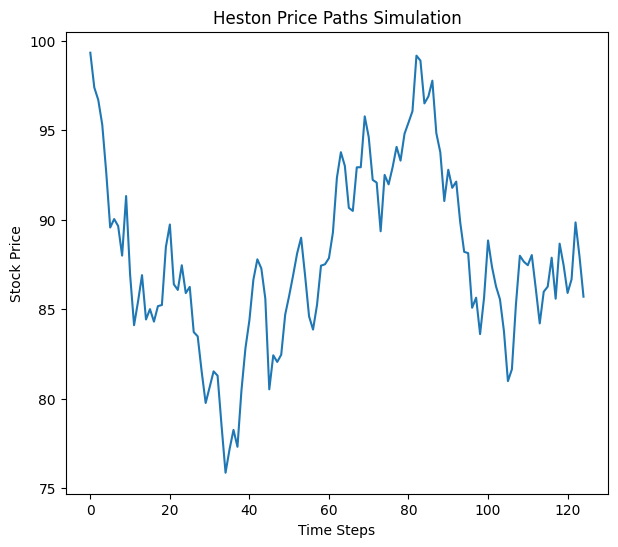

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


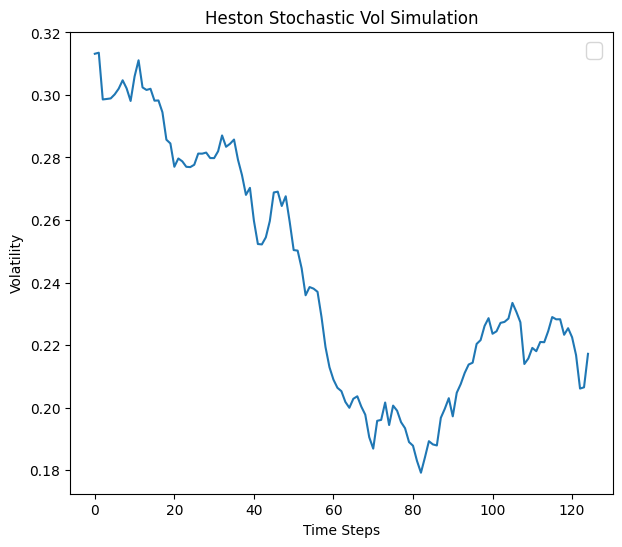

In [ ]:
np.random.seed(402)
prices,sigs = generate_heston_paths(S=100, T =1, r =0, kappa =2, theta = 0.03, v_0 =0.1, rho =-0.7, sigma = 0.1, 
                          steps = 125, Npaths =1, return_vol=True)


plt.figure(figsize=(7,6))
plt.plot(prices.T)

plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(7,6))
plt.plot(np.sqrt(sigs).T)
#plt.axhline(np.sqrt(theta), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend(fontsize=15)
plt.show()

In [ ]:
len(x )

250

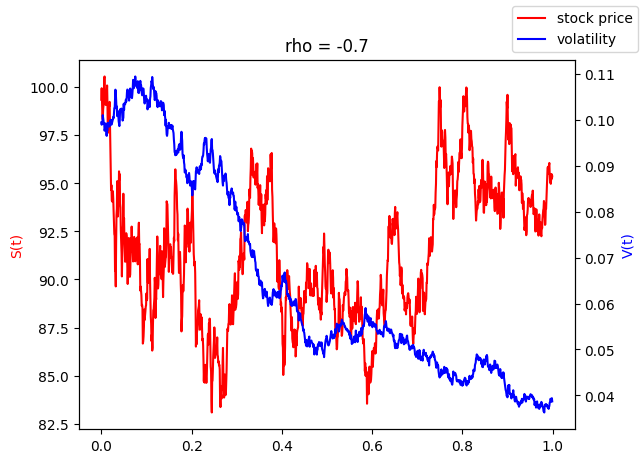

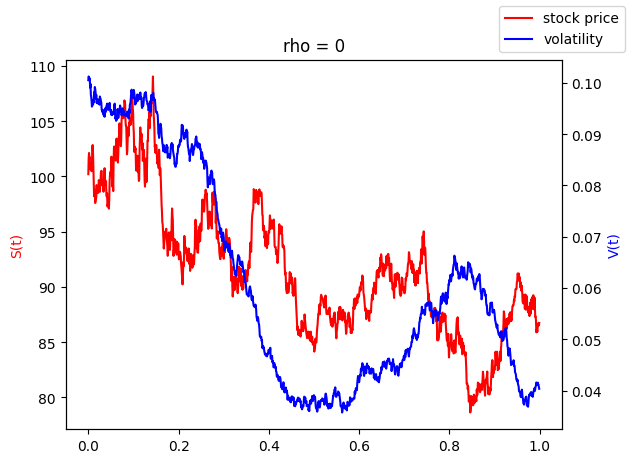

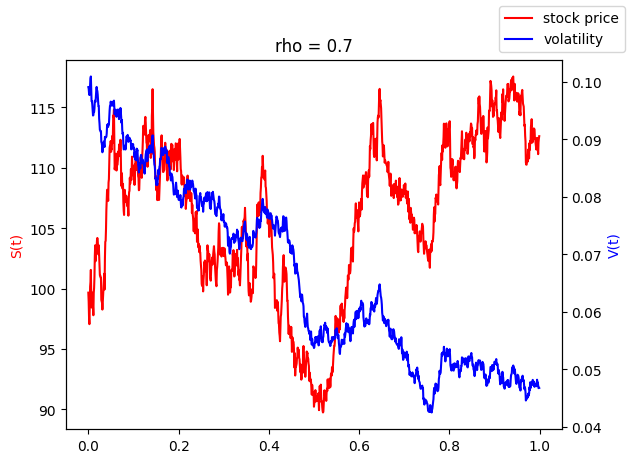

In [ ]:
import matplotlib.pyplot as plt
rhos =[-0.7,0,0.7]
n=125
T =1

#n=1250
#T =1
x = np.arange(0, 1, T/n)
for rho in rhos:
    prices,sigs = generate_heston_paths(S=100, T =T, r =0, kappa =2, theta = 0.03, v_0 =0.1, rho =rho, sigma = 0.1, 
                          steps = n, Npaths =1, return_vol=True)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(x, prices[0],'r-', label='stock price')
    ax2.plot(x, sigs[0], 'b-', label='volatility')
    
    ax1.set_ylabel('S(t)', color ='r')
    ax2.set_ylabel('V(t)', color= 'b')
    fig.legend()
    plt.title(f'rho = {rho}')
    plt.show()

In [ ]:

def pricer_heston_call_option(S0,v0,r,rho,kappa,theta,sigma,T, timesteps,K,simulation_size):
    

    call_hat, CI, MSE = [], [], [] 
    eff_CR,abs_error_CR =[], [] 

    disc_factor = np.exp(-r*T) 
    for N in simulation_size:
        
        
        prices = generate_heston_paths(S0, T ,r ,kappa ,theta , v0, rho, sigma ,timesteps ,N , False)
        last_price = prices[:, -1]
        payoff = np.maximum(last_price - K,0)

        disc_payoff = disc_factor * payoff
        tempsum = np.sum(disc_payoff)
        tempsum2 = np.sum(disc_payoff**2)
   
        crude_MC = tempsum / N # compute crude Monte Carlo

        # compute variance of crude MC
        s2 = tempsum2/(N-1) - (N/(N-1))*crude_MC**2
        mse = s2/N
        upper_CI = crude_MC +1.96*(mse**0.5)
        lower_CI = crude_MC -1.96*(mse**0.5)
        ci = [lower_CI, upper_CI]

        #efficiency
        eff = 1 / mse
        error = abs(BS_put - crude_MC)

        call_hat.append(crude_MC)
        MSE.append(mse)
        CI.append(ci)
        eff_CR.append(eff)
        abs_error_CR.append(error)

    results_crude_MC = pd.DataFrame({'N':simulation_size, 'P0_hat':call_hat, 'MSE':MSE, '95% CI':CI,
                                     'Abs. Error': abs_error_CR, 'Efficiency': eff_CR })

  

    return results_crude_MC

In [ ]:
S0 = 100
v0 = 0.1
r = 0
rhos = [-0.7, 0, 0.7]
kappa = 2
theta = 0.03
sigma = 0.1
T = 0.5
timesteps = 125
K = S0
simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6]



results_heston = []
for rho in rhos:
    heston_call_price = pricer_heston_call_option(S0,v0,r,rho,kappa,theta,sigma,T,timesteps,K,simulation_size)
    results_heston.append(heston_call_price)
    print('-------------------------------------------------------------------')
    print(f'rho = {rho}')
    print('-------------------------------------------------------------------')
    display(heston_call_price)
    print('\n')

-------------------------------------------------------------------
rho = -0.7
-------------------------------------------------------------------


,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,100,6.708202,1.133061,"[4.621873182541023, 8.794530239144933]",7.068569,0.882565
1,1000,7.878257,0.142467,"[7.1384591087206175, 8.618055477987605]",5.898514,7.019168
2,10000,7.789726,0.014639,"[7.552579846569825, 8.026872510238356]",5.987045,68.309219
3,100000,7.637331,0.001420,"[7.563462312383635, 7.711199250984498]",6.139440,704.034503
4,1000000,7.632318,0.000143,"[7.608885541539403, 7.655751426807735]",6.144453,6996.139879




-------------------------------------------------------------------
rho = 0
-------------------------------------------------------------------


,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,100,8.224620,1.450573,"[5.86400105404587, 10.58523927630455]",5.552151,0.689383
1,1000,7.959702,0.159733,"[7.1763569513048555, 8.743047912208015]",5.817069,6.260449
2,10000,7.531481,0.015746,"[7.2855316529156084, 7.777430575968269]",6.245290,63.506823
3,100000,7.699280,0.001610,"[7.620627630322359, 7.77793304765482]",6.077491,620.990241
4,1000000,7.685759,0.000161,"[7.660921795700812, 7.7105961119270905]",6.091012,6227.422603




-------------------------------------------------------------------
rho = 0.7
-------------------------------------------------------------------


,N,P0_hat,MSE,95% CI,Abs. Error,Efficiency
0,100,6.406895,1.429380,"[4.063584430839105, 8.75020552108325]",7.369876,0.699604
1,1000,7.834455,0.188364,"[6.983798059776436, 8.685112058335722]",5.942316,5.308883
2,10000,7.863453,0.018475,"[7.597041578843481, 8.12986428305664]",5.913318,54.126094
3,100000,7.699329,0.001775,"[7.616741667483596, 7.781917062751623]",6.077442,563.224353
4,1000000,7.696358,0.000178,"[7.670228164580516, 7.722487767219809]",6.080413,5626.520786


### Exercise 5b

Heston volatility model with conditional Monte-Carlo

In [ ]:
#Q5b
def q5b(S0,v0,r,rho,kappa,theta,sigma,T,timesteps,K, simulation_size):
    
    C0_hat = []
    MSE = []
    CI = []
    dt = T/timesteps
    sqrt_dt = dt**0.5
    const_1 = -0.5*rho**2*dt
    const_2 = dt/T
    const_3 = 1-rho**2
    const_4 = S0/K
    const_6 = K*np.exp(-r*T)
    np.random.seed(402)
    for N in simulation_size:
        XI = []
        D1 = []
        D2 = []
        
        Z = np.random.normal(0,1,size =(N, timesteps))*sqrt_dt
        prices, vol = generate_heston_paths(S0, T ,r ,kappa ,theta , v0, rho, sigma ,timesteps ,N , True)
        last_price = prices[:, -1]
        sum_vol = np.sum(vol[:], axis =1)
        payoff = np.maximum(last_price - K,0)
        xi = np.exp(const_1 * sum_vol + rho*np.sum(np.multiply(np.sqrt(vol[:]),Z), axis =1))
        sig_sq = const_2 * sum_vol
        sig = sig_sq**0.5
        const_5 = sig*(T*const_3)**0.5
        d1 = (np.log(const_4*xi)+(r+0.5*sig_sq*const_3)*T) / const_5
        d2 = d1 - const_5
        XI.append(xi)
        D1.append(norm.cdf(d1))
        D2.append(norm.cdf(d2))


        disc_payoff = np.subtract(np.multiply(XI,np.multiply(S0,D1)), np.multiply(const_6,D2))
        disc_payoff_sum = np.sum(disc_payoff)
        disc_payoff_sq_sum = np.sum(np.square(disc_payoff))

        mu = disc_payoff_sum/N
        ss = (disc_payoff_sq_sum - N*mu**2) / (N-1)
        mse = ss/N
        ci = [mu-1.96*(mse**0.5), mu+1.96*(mse**0.5)]
        C0_hat.append(mu)
        MSE.append(mse)
        CI.append(ci)

    df = pd.DataFrame({'N':simulation_size, 'C0_hat':C0_hat, 'MSE':MSE, '95% CI':CI}) 

    return df

In [ ]:
simulation_size = [10**2, 10**3, 10**4, 10**5, 10**6]
results = []

print ("Heston Volatility Model with CONDITIONAL Monte Carlo")
for rho in rhos:
    temp = q5b(S0,v0,r,rho,kappa,theta,sigma,T,timesteps,K,simulation_size)
    results.append(temp)
    print('-------------------------------------------------------------------')
    print(f'rho = {rho}')
    print('-------------------------------------------------------------------')
    display(temp)
    print('\n')

Heston Volatility Model with CONDITIONAL Monte Carlo
-------------------------------------------------------------------
rho = -0.7
-------------------------------------------------------------------


,N,C0_hat,MSE,95% CI
0,100,7.609330,0.927474,"[5.721742767228037, 9.49691722784857]"
1,1000,8.251351,0.071551,"[7.7270684627819906, 8.775633598123848]"
2,10000,7.661434,0.006443,"[7.504111732701577, 7.818755780835981]"
3,100000,7.644898,0.000636,"[7.595448889162116, 7.69434630967706]"
4,1000000,7.656740,0.000064,"[7.641029651222923, 7.672451151668413]"




-------------------------------------------------------------------
rho = 0
-------------------------------------------------------------------


,N,C0_hat,MSE,95% CI
0,100,7.602535,2.006509e-03,"[7.514738595534241, 7.690331358172224]"
1,1000,7.654216,1.825131e-04,"[7.627737166867271, 7.68069535619381]"
2,10000,7.649344,1.906872e-05,"[7.640785319335959, 7.657903077673509]"
3,100000,7.648103,1.898313e-06,"[7.6454021527976, 7.65080309992882]"
4,1000000,7.648723,1.898280e-07,"[7.647868875962417, 7.649576790619359]"




-------------------------------------------------------------------
rho = 0.7
-------------------------------------------------------------------


,N,C0_hat,MSE,95% CI
0,100,8.666648,0.729105,"[6.993050014914845, 10.34024634233227]"
1,1000,7.200167,0.062660,"[6.709541393617377, 7.6907919670807114]"
2,10000,7.654985,0.006461,"[7.497435761512028, 7.812534272919516]"
3,100000,7.630635,0.000638,"[7.581126833935637, 7.680142578255288]"
4,1000000,7.642248,0.000064,"[7.62656491197338, 7.6579315439836675]"


###Exercise 5c
 Compare model's efficiency for the Heston volatility model.


In [ ]:
for i in range(3): 
    eff_MC = (results_heston[i]['MSE'])**(-1)
    eff_condMC = (results[i]['MSE'])**(-1)
    eff_change = (eff_condMC - eff_MC)/eff_MC *100
    print(f'Compare to Monte-Carlo, Antithetic Variates increases efficiency by % {eff_change}')

Compare to Monte-Carlo, Antithetic Variates increases efficiency by % 0     22.166275
1     99.111199
2    127.223776
3    123.155843
4    122.464035
Name: MSE, dtype: float64
Compare to Monte-Carlo, Antithetic Variates increases efficiency by % 0    72193.392518
1    87418.611672
2    82476.783373
3    84729.617027
4    84492.422910
Name: MSE, dtype: float64
Compare to Monte-Carlo, Antithetic Variates increases efficiency by % 0     96.045696
1    200.613932
2    185.938571
3    178.280129
4    177.585278
Name: MSE, dtype: float64
